# 17. Bag of Words

In [1]:
import codecs
import pandas as pd

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import torch.nn as nn
import torch.utils.data as Data

import numpy as np
import random

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 17.1 Prepare Data

In [3]:
f = codecs.open("data/reviews.txt", 'r', 'utf-8')
f.read()[:500]

'# G마켓에 좋은 평만 있어서 사봤는데.. 정말 진짜 진짜 사지마세요. 개. 쓰. 레. 기 (진심) 입니다. 액정부터 짜증나는 TN패널에, 하드 SSD인걸로 알았는데, 속도는 저질 SD카드 꽂아 놓은것 같습니다. 정말 느려터집니다. 저는 단지 인터넷 뱅킹만 할려고, 샀단 말입니다. 그런데 인터넷 뱅킹 프로그램까는데만 10~20분 걸립니다. 뭐약!! 이게!! 분노로 인해 볼때마다 짜증납니다. 밤에 잠도 안오고요.. 사시면 분명 후회하실겁니다. 아! 진짜 G마켓 프리미엄평으로 실날하게 사진찍어서 올리려고했는데, 먹고 산다고 바빠서 프리미엄 평 못 올린게 정말 천추의 한이네요!!\n# 원래 그런 줄 알고 사는 "저가 제품"이라고 생각합니다만. IPS라는 언급이 없으니 당연히 TN 패널일 테고, EMMC는 SSD가 아니고 SD 카드 내장된 것 같은 것이라 원래 SSD보다 느린 것이고, CPU도 아톰이니 뭐 당연히 느리죠. 그런 것 다 감안하고 "싸고 가볍다"는 조건으로 사는 제품인데요. 뭐 '

## 17.2 Extract Setences

In [4]:
keywords = ["발열", "소음"]

for keyword in keywords :
    temp_list = []
    save_name = "data/reviews_" + keyword + ".txt"
    f = codecs.open("data/reviews.txt", 'r', 'utf-8')
    t = codecs.open(save_name, 'w', 'utf-8')
    
    while True:
        line = f.readline()
        if not line: break
        if keyword in line :
            temp_list.append(line)
            
    set_list = list(set(temp_list))
    
    for item in set_list :
        t.write(item)
        
    f.close()
    t.close()

In [5]:
f = codecs.open("data/reviews_발열.txt", 'r', 'utf-8')
f.read()[:500]

'# 이게 게이밍 노트북이라뇨?? 1050 달고 게이밍이라고 하다니.. 고사양게임들은 사양 타협을 해야되겠네요. 라이트한 게임유저면 1050ti 정도면 상관없지만 게이밍이라고 말할려면 최소 1060은 가셔야됩니다. 그리고 이제품 발열 자체가 상당하던데 게이밍으론 부적절한 제품입니다. 예를 들어 cpu가 100도를 견딘다고 하면 매일 90도 이상 계속 돌아가면 문제가 생기는건 당연하죠. 그로인해 노트북 회사들은 발열제어에 힘쓰는거구요. 뒷판 파공을 해놨지만 저거 전혀 쓸모 없습니다. 애초에 저런식으로 파공을 해야됬나 싶을정도.. 삼성 이번꺼 정말 실망스러운 제품입니다. 대기업이라 as는 믿고 맡기겠지만 그거 외에는 장점이 없는 제품이네요..\n# 삼성이라는 브랜드에 외산 노트북과 엇비슷한 가격이라는 점은 매우 강점인 것 같습니다. 아무래도 노트북은 데스크탑과는 다르게 자가 수리(부품교환)이 어렵다보니 as센터를 이용해야하는데, 삼성의 as는 타사의 추종을 불허하잖아요? 성능은 중간급 정도'

## 17.3 Load Scored Data

In [6]:
filename = "data/score_발열.xlsx"
sheet_name = "Sheet1"
data = pd.read_excel(filename, sheet_name = sheet_name, header = 0)

csv_data = [item.replace("#", "").strip() for item in data['Review']]
csv_label = data['Score']

In [7]:
csv_data[:5]

['발열히 심한거 같은데 여름이라 그런가?..',
 '발열이좀 심한거 같아서 걱정이에요',
 '발열이심하더라구요',
 '발열이너무심한게 제일큰 단점인것 같고 그외에 불편한점은',
 '발열이...정말...심합니다']

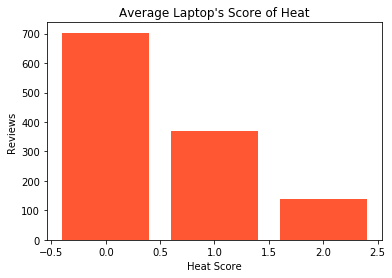

In [8]:
scores = [sum(csv_label == 0), sum(csv_label == 1), sum(csv_label == 2)]
plt.bar(range(len(scores)),scores, color="#ff5733")

plt.title("Average Laptop's Score of Heat")
plt.xlabel("Heat Score")
plt.ylabel("Reviews")

plt.show()

## 17.4 Bag of Words

In [9]:
tokenizer = Okt()
doc = []

for sentence in csv_data :
    results= []
    tokens = tokenizer.pos(sentence, norm=True, stem=True)
        
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
    doc.append(" ".join(results).strip())

In [10]:
doc[:5]

['발열 히 심하다 같다 여름 그 런가',
 '발열 이 좀 심하다 같다 걱정',
 '발열 심하다',
 '발열 이 너 무심하다 제일 크다 단점 것 같다 그 외 불편하다 점',
 '발열 정말 심하다']

In [11]:
# CountVectorizer
cnv = CountVectorizer(ngram_range=(1,1), min_df = 3)

data = cnv.fit_transform(doc).toarray()
label = csv_label.values

In [12]:
# TF-IDF Vectorizer
# tfidv = TfidfVectorizer().fit(data)
# data = tfidv.transform(data).toarray()

# data = pd.DataFrame(data)
# data = (data - data.mean()) / (data.max() - data.min() + 1)

In [13]:
cnv.vocabulary_

{'발열': 112,
 '심하다': 156,
 '같다': 13,
 '여름': 187,
 '걱정': 16,
 '무심하다': 104,
 '크다': 266,
 '단점': 57,
 '불편하다': 125,
 '정말': 237,
 '확실하다': 292,
 '심해': 157,
 '노트북': 45,
 '쿨러': 263,
 '사용': 134,
 '크게': 265,
 '진짜': 250,
 '너무': 43,
 '많이': 93,
 '있다': 218,
 '장시간': 228,
 '높다': 47,
 '프로그램': 275,
 '한편': 283,
 '이다': 204,
 '심다': 155,
 '밧데리': 113,
 'cpu': 4,
 '용량': 200,
 '빼다': 131,
 '괜찮다': 22,
 '느낌': 50,
 '하지만': 281,
 '자판': 221,
 '조금': 241,
 '속도': 149,
 '매우': 94,
 '좋다': 244,
 '이전': 211,
 '하다': 279,
 '뜨겁다': 83,
 '가볍다': 10,
 '조용하다': 242,
 '마음': 88,
 '듭니': 72,
 '돌아가다': 65,
 '불량': 124,
 '심해지다': 158,
 '생기다': 141,
 '소리': 147,
 '나다': 38,
 '그렇다': 31,
 '부분': 122,
 '문제': 107,
 '끊기다': 37,
 '쓰다': 160,
 '약간': 175,
 '게임': 18,
 '돌리다': 64,
 '정도': 236,
 '성능': 145,
 '라면': 85,
 '지다': 249,
 '이렇다': 206,
 '부팅': 123,
 '화상': 289,
 '원래': 202,
 '모르다': 100,
 '않다': 171,
 '구매': 24,
 '신분': 154,
 '야하다': 174,
 '제외': 239,
 '자주': 220,
 '발생': 111,
 '삼성': 137,
 '소음': 148,
 '치다': 259,
 '만족하다': 91,
 '배터리': 116,
 '빠르다': 128,
 '무엇': 105,
 '생각': 

## 17.5 Train-Test Split

In [14]:
dim = len(cnv.vocabulary_)

In [15]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)

print(len(train_data))
print(len(test_data))

908
303


In [16]:
x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

In [17]:
y.size() , x.size()

(torch.Size([908]), torch.Size([908, 295]))

In [18]:
train_data = Data.TensorDataset(x, y)

batch_size = 10

train_loader  = Data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1,
                                          drop_last = True)

## 17.6 Define and Train Model

In [19]:
linear1 = nn.Linear(dim, 200, bias = True)
linear2 = nn.Linear(200, 3, bias = True)
relu = nn.ReLU()

model = nn.Sequential(linear1, relu, linear2)

In [20]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 50

In [22]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/50], lter [20/90], Loss: 0.9519
Epoch [1/50], lter [40/90], Loss: 1.0120
Epoch [1/50], lter [60/90], Loss: 0.6827
Epoch [1/50], lter [80/90], Loss: 0.8269
Epoch [2/50], lter [20/90], Loss: 0.2934
Epoch [2/50], lter [40/90], Loss: 0.4353
Epoch [2/50], lter [60/90], Loss: 0.3538
Epoch [2/50], lter [80/90], Loss: 0.5173
Epoch [3/50], lter [20/90], Loss: 0.6698
Epoch [3/50], lter [40/90], Loss: 0.5007
Epoch [3/50], lter [60/90], Loss: 0.2530
Epoch [3/50], lter [80/90], Loss: 0.6136
Epoch [4/50], lter [20/90], Loss: 0.2339
Epoch [4/50], lter [40/90], Loss: 0.2854
Epoch [4/50], lter [60/90], Loss: 0.1022
Epoch [4/50], lter [80/90], Loss: 0.1698
Epoch [5/50], lter [20/90], Loss: 0.1024
Epoch [5/50], lter [40/90], Loss: 0.4401
Epoch [5/50], lter [60/90], Loss: 0.1557
Epoch [5/50], lter [80/90], Loss: 0.0826
Epoch [6/50], lter [20/90], Loss: 0.2376
Epoch [6/50], lter [40/90], Loss: 0.2841
Epoch [6/50], lter [60/90], Loss: 0.2698
Epoch [6/50], lter [80/90], Loss: 0.1092
Epoch [7/50], lt

Epoch [50/50], lter [20/90], Loss: 0.0036
Epoch [50/50], lter [40/90], Loss: 0.1335
Epoch [50/50], lter [60/90], Loss: 0.0521
Epoch [50/50], lter [80/90], Loss: 0.0004
Learning Finished!


## 17.7 Test Model

In [23]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)

test_data = Data.TensorDataset(x_test, y_test)

test_loader  = Data.DataLoader(dataset=test_data,
                                          batch_size=1,
                                          shuffle=True)

In [24]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, pre = torch.max(outputs.data, 1)
    total += 1
    correct += (pre == labels).sum()
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 78.877888 %


## 17.8 Test Sentence

In [25]:
def IsitHot(string) :
    
    results= []
    tokens = tokenizer.pos(string, norm=True, stem=True)

    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
   
    sample = cnv.transform([" ".join(results).strip()]).toarray()
    sample = torch.from_numpy(sample).type(torch.FloatTensor)
    outputs = model(sample)
    pre = torch.max(outputs.data, 1)[1].numpy()
    
    if pre == 0 : 
        print("분석 결과 : 발열 거의 없음")
    elif pre == 1 :
        print("분석 결과 : 발열 조금 있음")
    else :
        print("분석 결과 : 발열 매우 심함")

In [26]:
IsitHot("노트북이 너무 뜨거워요")

분석 결과 : 발열 매우 심함


In [27]:
IsitHot("발열을 잘 잡았네요")

분석 결과 : 발열 거의 없음
